In [1]:
import scvelo as scv
import scanpy as sc
import pickle as pickle
from eval_utils import cross_boundary_correctness, inner_cluster_coh
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import unitvelo as utv
method = 'UniTVelo_independent'

(Running UniTVelo 0.2.5)
2023-01-02 16:36:01


In [2]:
datasets = ['MouseErythroid', 'HumanDevelopingBrain', 'DentateGyrus', 'Pancreas_with_cc', 'MouseBoneMarrow',  'HumanBoneMarrow']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

MouseErythroid
Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:35) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
------> Manully Specified Parameters <------
N_TOP_GENES:	3000
FIT_OPTION:	2
DENSITY:	Raw
REORDER_CELL:	Hard
AGGREGATE_T:	False
------> Model Configuration Settings <------
LEARNING_RATE:	0.01
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Current working dir is /nfs/team283/aa16/fate_benchmarking.
Results will be stored in res folder
Filtered out 79 g

Loss (Total): 1172.743, (Spliced): 397.416, (Unspliced): 775.327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [1:50:28<00:00,  1.73it/s]

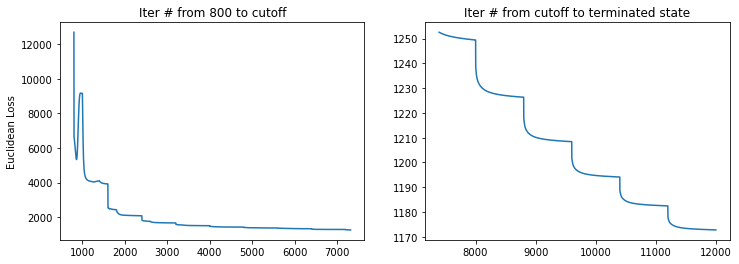

Loss (Total): 1172.743, (Spliced): 397.416, (Unspliced): 775.327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [1:51:49<00:00,  1.79it/s]

Total loss 1172.743, vgene loss 1172.743


  0%|          | 0/9815 [00:00<?, ?cells/s]

  0%|          | 0/9815 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.06286168403620918, ('Blood progenitors 2', 'Erythroid1'): 0.10568071267321945, ('Erythroid1', 'Erythroid2'): -0.6776158840100983, ('Erythroid2', 'Erythroid3'): -0.6008254305989152}
Total Mean: -0.3089055714930008
# In-cluster Coherence
{'Blood progenitors 1': 0.99610156, 'Blood progenitors 2': 0.9952664, 'Erythroid1': 0.9944912, 'Erythroid2': 0.9960428, 'Erythroid3': 0.99487495}
Total Mean: 0.9953554272651672
# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.06286168403620918, ('Blood progenitors 2', 'Erythroid1'): 0.10568071267321945, ('Erythroid1', 'Erythroid2'): -0.6776158840100983, ('Erythroid2', 'Erythroid3'): -0.6008254305989152}
Total Mean: -0.3089055714930008
# In-cluster Coherence
{'Blood progenitors 1': 0.99610156, 'Blood progenitors 2': 0.9952664, 'Erythroid1': 0.9944912, 'Erythroid2': 0.9960428, 'Erythroid3': 0.99487495}
Total Mea

Loss (Total): 90.436, (Spliced): 50.427, (Unspliced): 40.010:  45%|███████████████████████████████████████████████████████████▍                                                                         | 5365/12000 [43:17<57:01,  1.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss (Total): 56.279, (Spliced): 33.272, (Unspliced): 23.006:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11859/12000 [1:41:23<01:16,  1.85it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_r

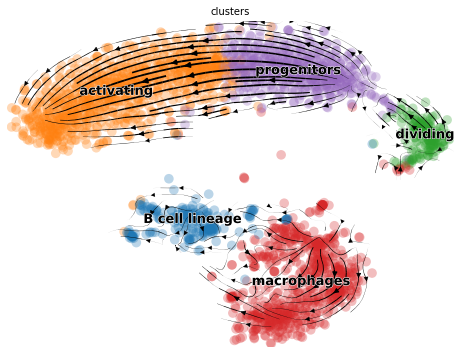

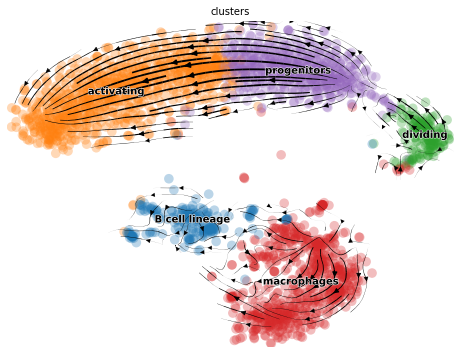

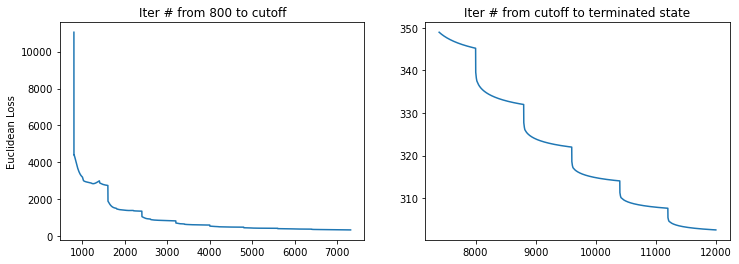

Loss (Total): 302.560, (Spliced): 178.808, (Unspliced): 123.751: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [32:46<00:00,  6.10it/s]

Total loss 302.560, vgene loss 302.560


  0%|          | 0/5780 [00:00<?, ?cells/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
for dataset in datasets:
    print(dataset)
    # Load and setup data:
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata.var['highly_variable'] = True
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=3000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    velo = utv.config.Configuration()
    velo.N_TOP_GENES = 3000
    velo.R2_ADJUST = True
    velo.IROOT = None
    velo.FIT_OPTION = '2'
    velo.GPU = 0
    velo.vgenes = 'offset'
    scv.pp.neighbors(adata)
    adata = utv.run_model(adata, 'clusters', config_file=velo)
    scv.tl.velocity_graph(adata, vkey='velocity')
    scv.tl.velocity_embedding(adata, vkey='velocity')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax, legend_fontsize = 13)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_UniTVelo_independent.png')
    # Calculate performance metrics:
    adata.layers['velocity'][pd.isna(adata.layers['velocity'])] = 0
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    if exists(save_dir + dataset + '_CBDC_scores.csv'):
        tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
    else:
        tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean'],
                 index = [method])
    cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
                for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
    tab.loc[method,:] = cb_score + [np.mean(cb_score)]
    tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    if exists(save_dir + dataset + '_ICC_scores.csv'):
        tab = pd.read_csv(save_dir + dataset + '_ICC_scores.csv', index_col = 0)
    else:
        tab = pd.DataFrame(columns = list(np.unique(np.concatenate(ground_truth))) + ['Mean'],
                 index = [method])
    icc_score = [np.mean(metrics['In-cluster Coherence'][x]) for x in np.unique(np.concatenate(ground_truth))]
    tab.loc[method,:] = icc_score + [np.mean(icc_score)]
    tab.to_csv(save_dir + dataset + '_ICC_scores.csv')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.png')